In [2]:
import os
import numpy as np
import noisereduce as nr
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
def extract_features(audio_path):
    # Loading audio file
    audio, sample_rate = librosa.load(audio_path, sr=None) 
    # audio, sample_rate = librosa.load(audio_path) #if didnt use 'sr=none' so, it will resample all audio to 22050 hz
    #denoising audio
    denoised_audio = nr.reduce_noise(y=audio, sr=sample_rate)

    # Normalize the audio signal
    # normalized_audio = librosa.util.normalize(denoised_audio)
    
    # Extract features
    #melfrequency cepstral coeff
    mfccs = librosa.feature.mfcc(y=denoised_audio, sr=sample_rate, n_mfcc=13) #tone of audio file
    chroma = librosa.feature.chroma_stft(y=denoised_audio, sr=sample_rate) #energy distrubition data based on pitch
    # zero_crossing_rate = librosa.feature.zero_crossing_rate(y=denoised_audio)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=denoised_audio, sr=sample_rate) #indicates centre of mass in freq
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=denoised_audio, sr=sample_rate) #finds the spread range of freq around spec_centr
    spectral_rolloff = librosa.feature.spectral_rolloff(y=denoised_audio, sr=sample_rate) #audio lo ekkada voice fade out ayyindho will find
    spectral_contrast = librosa.feature.spectral_contrast(y=denoised_audio, sr=sample_rate) #measures difference in amplitude(highs & lows)
    
    # Aggregate features into a single vector
    features = np.hstack([
        np.mean(mfccs, axis=1), 
        np.mean(chroma, axis=1), 
        # np.mean(zero_crossing_rate, axis=1),
        np.mean(spectral_centroid, axis=1),
        np.mean(spectral_bandwidth, axis=1),
        np.mean(spectral_rolloff, axis=1),
        np.mean(spectral_contrast, axis=1),
    ])


    
    return features

In [4]:
# loads all the audio files
def load_data(directory): 
    features_list = []
    labels_list = []
    
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            # Full path to the audio file
            audio_path = os.path.join(directory, file)
            
            # Extract features
            features = extract_features(audio_path)
            
            # Extract label (emotion) from filename
            label = file.split('-')[2]  # Example based on RAVDESS naming
            
            # Append features and label
            features_list.append(features)
            labels_list.append(label)
    print(f"files from path {directory} loaded successfully!")
    return np.array(features_list), np.array(labels_list)

# Specify the path to the audio files directory
audio_directory = '../data/data_mix_22/'  # Replace with your path
X, y = load_data(audio_directory)

KeyboardInterrupt: 

In [72]:
X,y

(array([[-6.85204163e+02,  2.92683239e+01, -1.16131544e+01, ...,
          2.67038660e+01,  3.15645214e+01,  4.12403409e+01],
        [-6.70228149e+02,  3.32655334e+01,  6.18956536e-02, ...,
          2.32110888e+01,  2.54114769e+01,  3.46327608e+01],
        [-8.13721252e+02,  3.00108395e+01, -3.57927352e-01, ...,
          2.52857882e+01,  2.35197606e+01,  3.56836316e+01],
        ...,
        [-7.53665771e+02,  4.98163643e+01,  5.20134830e+00, ...,
          1.75859713e+01,  2.15770262e+01,  3.94272664e+01],
        [-7.14447144e+02,  4.77639198e+01,  3.49663663e+00, ...,
          2.29158794e+01,  2.62998495e+01,  4.26703847e+01],
        [-7.83972046e+02,  4.75854416e+01,  7.52260065e+00, ...,
          2.30660004e+01,  2.59580114e+01,  4.14927615e+01]]),
 array(['06', '05', '08', ..., '01', '08', '08'], dtype='<U2'))

In [67]:
# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])
# print("Number of features:", X_train.shape[1]) # datapoints

Number of training samples: 1056
Number of testing samples: 264


In [68]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight="balanced") # adding class_weight make model also concentrate on underrepresented classes too.
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # adding class_weight make morel also concentrate on underrepresented classes too.

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [31]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
# print(f"confidence score: {}")
print("Classification Report:")
print(classification_report(y_test, y_pred)) # "zero_division=1" replaces undifined values with 1
#accuracy===59.375

Accuracy: 0.5303030303030303
Classification Report:
              precision    recall  f1-score   support

          01       0.50      0.38      0.43        16
          02       0.55      0.89      0.68        37
          03       0.44      0.61      0.51        28
          04       0.40      0.21      0.28        47
          05       0.67      0.79      0.72        28
          06       0.64      0.39      0.48        41
          07       0.46      0.54      0.50        35
          08       0.59      0.53      0.56        32

    accuracy                           0.53       264
   macro avg       0.53      0.54      0.52       264
weighted avg       0.53      0.53      0.51       264



# Hyperparameter tuning

In [47]:
#hyperparameter tuning using grid search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

rf_model = grid_search.best_estimator_

print("Best estimater:", grid_search.best_estimator_)
print("Old Accuracy:", accuracy_score(y_test, y_pred))

#accuracy=====59.027

Best estimater: RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)
Old Accuracy: 0.5303030303030303


In [48]:
#after hyperparameter tuning...making predictions on test set again to get new accuracy!
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
# print(f"confidence score: {}")
print("Classification Report:")
print(classification_report(y_test, y_pred,zero_division=1))


Accuracy: 0.5113636363636364
Classification Report:
              precision    recall  f1-score   support

          01       0.42      0.31      0.36        16
          02       0.53      0.86      0.66        37
          03       0.39      0.57      0.46        28
          04       0.41      0.19      0.26        47
          05       0.69      0.79      0.73        28
          06       0.64      0.44      0.52        41
          07       0.41      0.43      0.42        35
          08       0.56      0.56      0.56        32

    accuracy                           0.51       264
   macro avg       0.51      0.52      0.50       264
weighted avg       0.51      0.51      0.49       264



In [49]:
le=joblib.load('label_encoder.pkl')
# lables = le.fit_transform(emotion_labels[1])
print("Classes in LabelEncoder:", le.classes_)



Classes in LabelEncoder: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


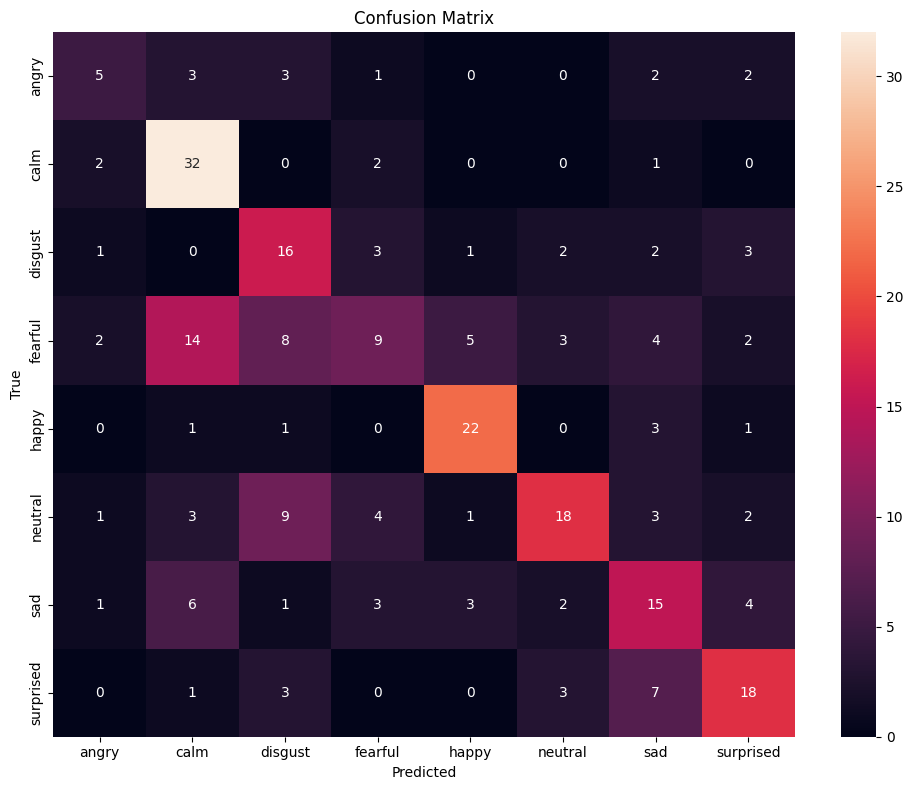

In [50]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
#saving the model
joblib.dump(rf_model, 'best_rf_model.joblib')
print("Model saved as 'best_rf_model.joblib'")

NameError: name 'joblib' is not defined

# TESTING

In [ ]:
#testing the model

model = joblib.load('../notebooks/best_rf_model.joblib')
print("Model loaded successfully.")

#checking the accuracy of the model

# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Model Accuracy:", accuracy)


Model loaded successfully.


In [53]:
#checking the accuracy of the model

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


Model Accuracy: 0.5113636363636364


In [6]:
def test_new_audio(file_path):
    # Extract features from the new audio file
    features = extract_features(file_path)
    
    # Reshape the features array to match the input format for the model
    features = features.reshape(1, -1)
    
    # Predict the emotion
    predicted_label = model.predict(features)
    
    return predicted_label[0]

# Test the model with a new audio file
# new_audio_path = '../test/Happy.m4a'  # Replace with your file path
# predicted_emotion = test_new_audio(new_audio_path)
# print(f"Predicted Emotion: {predicted_emotion}")

In [7]:
emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
def test_new_audio111(file_path):
    # Extract features from the new audio file
    features = extract_features(file_path)
    
    # Reshape the features array to match the input format for the model
    features = features.reshape(1, -1)
    
    # Predict the emotion
    predicted_label = model.predict(features)[0]
    
    # Convert the numeric label to emotion type
    predicted_emotion = emotion_labels.get(predicted_label, "Unknown")
    
    return predicted_emotion, predicted_label

# Test the model with a new audio file
# new_audio_path = '../CREMA/1001_IEO_DIS_HI.wav'  # Replace with your file path
# predicted_emotion, predicted_label = test_new_audio111(new_audio_path)
# print(f"Predicted Emotion: {predicted_emotion}")
# print(f"predicted label: {predicted_label}")

In [40]:
import os

# Directory containing the test audio files
test_audio_directory = '../CREMA/'  # Replace with your directory path

# Function to test and predict emotion for each file in a directory
def test_multiple_files(directory_path):
    results = {}
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".wav"):  # Only process .wav files
            file_path = os.path.join(directory_path, filename)
            predicted_emotion, predicted_label = test_new_audio111(file_path)
            results[filename] = predicted_emotion
            print(f"File: {filename},\npredicted label: {predicted_label}, Predicted Emotion: {predicted_emotion}")
    
    return results

# Test all audio files in the directory
test_results = test_multiple_files(test_audio_directory)

File: 1022_ITS_ANG_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1037_ITS_ANG_XX.wav,
predicted label: 07, Predicted Emotion: disgust
File: 1060_ITS_NEU_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1075_ITS_NEU_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1073_IOM_DIS_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1066_IOM_DIS_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1078_IWL_SAD_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1029_TAI_FEA_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1039_IEO_SAD_MD.wav,
predicted label: 02, Predicted Emotion: calm
File: 1008_TAI_HAP_XX.wav,
predicted label: 07, Predicted Emotion: disgust
File: 1018_TSI_FEA_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1028_IEO_SAD_HI.wav,
predicted label: 02, Predicted Emotion: calm
File: 1039_TSI_HAP_XX.wav,
predicted label: 02, Predicted Emotion: calm
File: 1064_ITS_HAP_XX.wav,
predicted label: 07, Predicted 

KeyboardInterrupt: 

In [37]:
# Map for emotion labels in RAVDESS dataset filenames
emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


# Function to extract actual emotion from filename
def get_actual_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    # print(f"file name: {emotion_code}")
    return emotion_code, emotion_mapping.get(emotion_code, "unknown")


def test_and_evaluate(directory_path):
    correct_predictions = 0
    total_files = 0
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".wav"):  # Only process .wav files
            file_path = os.path.join(directory_path, filename)
            emotion_code, actual_emotion = get_actual_emotion_from_filename(filename)
            
            # print(f"act {actual_emotion}")
            
            predicted_emotion = str(test_new_audio111(file_path)[1])
            
            # print(f"pred em {type(predicted_emotion[1])}")

            # Compare actual vs predicted
            is_correct = False
            if(emotion_code == predicted_emotion):
                is_correct=True
            if is_correct:
                correct_predictions += 1
            total_files += 1
            
            # Print the result for each file
            print(f"File: {filename}, Actual Emotion: {actual_emotion}, Predicted Emotion: {predicted_emotion}, Correct: {is_correct}")
    
    # Print overall accuracy
    accuracy = correct_predictions / total_files if total_files > 0 else 0
    print(f"Overall Accuracy: {accuracy}")
    
    return accuracy


In [76]:
#evaluation of above test
test_accuracy = test_and_evaluate(directory_path = '../test/23_24/')

File: 03-01-07-02-01-01-23.wav, Actual Emotion: disgust, Predicted Emotion: 08, Correct: False
File: 03-01-04-02-01-02-23.wav, Actual Emotion: sad, Predicted Emotion: 07, Correct: False
File: 03-01-04-01-02-02-23.wav, Actual Emotion: sad, Predicted Emotion: 07, Correct: False
File: 03-01-07-01-02-01-23.wav, Actual Emotion: disgust, Predicted Emotion: 08, Correct: False
File: 03-01-05-02-02-01-23.wav, Actual Emotion: angry, Predicted Emotion: 05, Correct: True
File: 03-01-06-02-02-02-23.wav, Actual Emotion: fearful, Predicted Emotion: 03, Correct: False
File: 03-01-06-01-01-02-23.wav, Actual Emotion: fearful, Predicted Emotion: 08, Correct: False
File: 03-01-05-01-01-01-23.wav, Actual Emotion: angry, Predicted Emotion: 05, Correct: True
File: 03-01-08-01-02-01-23.wav, Actual Emotion: surprised, Predicted Emotion: 08, Correct: True
File: 03-01-08-02-01-01-23.wav, Actual Emotion: surprised, Predicted Emotion: 08, Correct: True
File: 03-01-03-02-01-02-24.wav, Actual Emotion: happy, Predict

In [77]:
#evaluation of above test
test_accuracy = test_and_evaluate(directory_path = '../data/data_half/')

File: 03-01-06-01-02-02-02.wav, Actual Emotion: fearful, Predicted Emotion: 06, Correct: True
File: 03-01-05-01-02-01-02.wav, Actual Emotion: angry, Predicted Emotion: 05, Correct: True
File: 03-01-02-01-02-01-06.wav, Actual Emotion: calm, Predicted Emotion: 02, Correct: True
File: 03-01-02-02-01-01-06.wav, Actual Emotion: calm, Predicted Emotion: 02, Correct: True
File: 03-01-05-02-01-01-02.wav, Actual Emotion: angry, Predicted Emotion: 05, Correct: True
File: 03-01-06-02-01-02-02.wav, Actual Emotion: fearful, Predicted Emotion: 06, Correct: True
File: 03-01-04-01-01-02-02.wav, Actual Emotion: sad, Predicted Emotion: 04, Correct: True
File: 03-01-07-01-01-01-02.wav, Actual Emotion: disgust, Predicted Emotion: 01, Correct: False
File: 03-01-07-02-02-01-02.wav, Actual Emotion: disgust, Predicted Emotion: 07, Correct: True
File: 03-01-04-02-02-02-02.wav, Actual Emotion: sad, Predicted Emotion: 04, Correct: True
File: 03-01-03-02-02-02-07.wav, Actual Emotion: happy, Predicted Emotion: 03,

## Test with custom DATA

In [22]:

import sounddevice as sd
from scipy.io.wavfile import write
import numpy as np


duration = 5
sample_rate = 22500

print("Recording...")

audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.int16)
sd.wait() 
print("Recording finished!")

# Save as a WAV file
audio_filename = "test_audio_new.wav"
write(audio_filename, sample_rate, audio_data)

print(test_new_audio111(audio_filename))

Recording...
Recording finished!
('angry', '05')
